In [7]:
# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.preprocessing import StandardScaler
from sklearn.inspection import permutation_importance

In [8]:

# Load sample dataset (Iris Dataset for classification)
data = load_iris()
X = data.data
y = data.target

In [9]:



# Split dataset into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Standardize the dataset for models that are sensitive to feature scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [10]:


# Initialize classifiers
classifiers = {
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "SVM": SVC(kernel='linear', random_state=42),  # Linear SVM for simplicity
    "LDA": LinearDiscriminantAnalysis(),
    "Logistic Regression": LogisticRegression(random_state=42)
}

In [11]:

# Function to calculate feature importance for each classifier
def calculate_feature_importance(classifiers, X_train, y_train):
    importance_results = {}

    for name, clf in classifiers.items():
        clf.fit(X_train, y_train)
        
        if name == "Decision Tree":
            importance_results[name] = clf.feature_importances_
        
        elif name == "Logistic Regression":
            # Coefficients of Logistic Regression (scaled by regularization)
            importance_results[name] = np.abs(clf.coef_[0])
        
        elif name == "SVM":
            # SVM uses the absolute value of coefficients as feature importance
            importance_results[name] = np.abs(clf.coef_[0]) if hasattr(clf, 'coef_') else None
        
        elif name == "LDA":
            # For LDA, the absolute values of the coefficients are used to determine importance
            importance_results[name] = np.abs(clf.coef_[0])
    
    return importance_results

# Calculate feature importance
importance_values = calculate_feature_importance(classifiers, X_train_scaled, y_train)


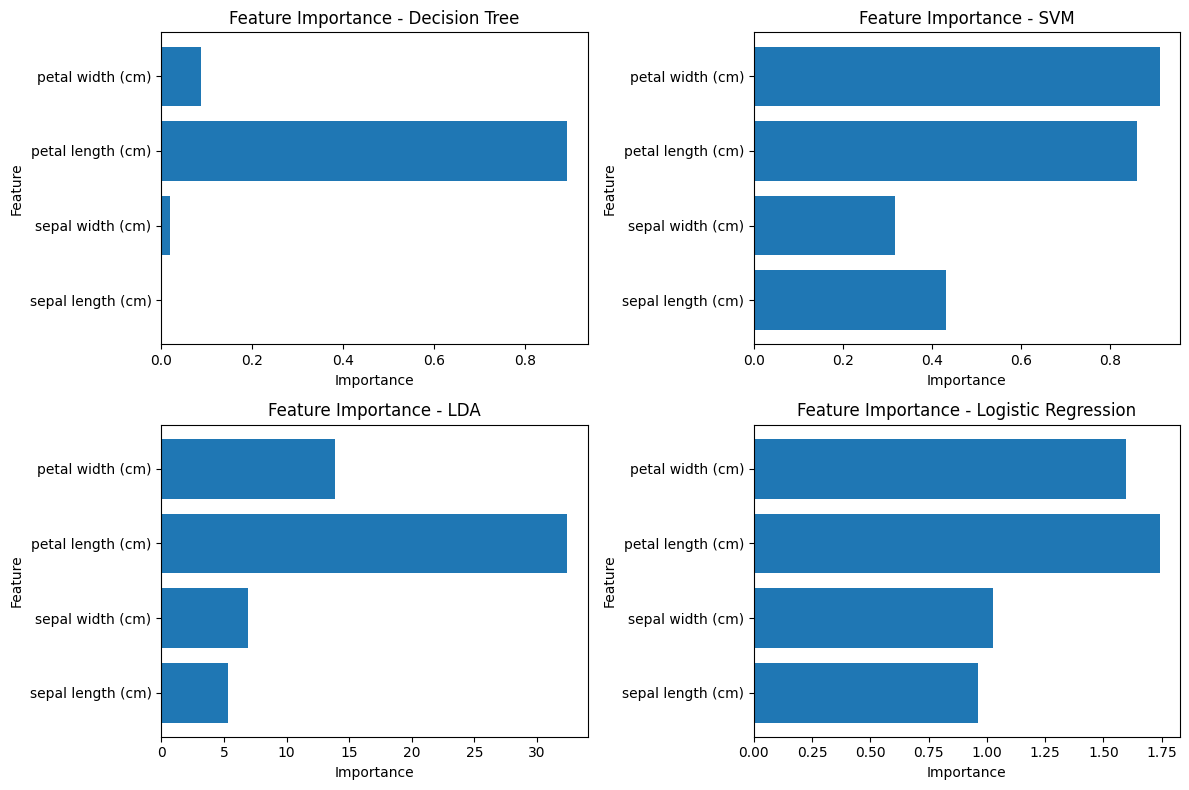

In [12]:


# Plot feature importance
def plot_feature_importance(importance_values, feature_names):
    plt.figure(figsize=(12, 8))
    
    for i, (name, importance) in enumerate(importance_values.items()):
        plt.subplot(2, 2, i+1)
        plt.barh(feature_names, importance)
        plt.title(f'Feature Importance - {name}')
        plt.xlabel('Importance')
        plt.ylabel('Feature')

    plt.tight_layout()
    plt.show()

# Feature names from the Iris dataset
feature_names = data.feature_names

# Plotting the feature importances
plot_feature_importance(importance_values, feature_names)

